In [1]:
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage

In [2]:
def nifti_loader(filename):
    x = nib.load(filename)
    img = np.asanyarray(x.dataobj)    
    return img

In [3]:
def smoothedDice(gt, pred):
    top_smooth = 0
    smooth = 1e-5
    intersection = np.sum(gt * pred)
    denominator = np.sum((gt + pred))
    f = (2.0 * intersection + top_smooth) / (denominator + smooth)
    return f

In [4]:
def generate_edge_distance_map_static(xn):
    '''
    you can generate edge map from a sample t2 lesion
    '''
    #calculate the euclidian distance transform
    edge = ndimage.distance_transform_edt(xn>0)
    
    #normalize
    edge /= np.max((edge))
    
    #invert
    edge =abs(1-edge)
    
    #zero outside of lesion
    edge = edge*xn
    
    #normalize
    edge /= np.max((edge))
    
    #add 1 to mitigate vanishing gradients
    edge = edge+1
    
    return edge

In [5]:
def spatial_regularization_loss(dist_map, pred):
    top_smooth = 0
    smooth = 5e-5
    reduce_axis = [1,2,3]
    #binarize distance map for calculating Dice
    gt = tf.cast((dist_map > 1), tf.float32)
    
    #calculate Dice loss
    y_true_o = tf.reduce_sum(gt, axis=reduce_axis)
    y_pred_o = tf.reduce_sum(pred, axis=reduce_axis)
    intersection = tf.reduce_sum(gt * pred, axis=reduce_axis)
#     print(intersection)
    denominator = y_true_o + y_pred_o
    dice = (2.0 * intersection + top_smooth) / (denominator + smooth)
    dice = tf.reduce_mean(dice)  # final reduce_mean across batches and channels
    
    #calculate binary cross entropy loss
    positive_block = tf.multiply( tf.cast(gt, tf.float32 ), tf.math.log( pred ))
    
    negative_block = tf.multiply( tf.subtract( 1.0, tf.cast(gt, tf.float32 ) ),tf.math.log( tf.add(tf.subtract( 1.0 , pred ),1e-9)))
    ce = -tf.add( positive_block, negative_block )
    #weight cross entropy by the distance maps
    ce = tf.multiply(dist_map,ce)
    ce = tf.reduce_sum(ce)/tf.reduce_prod(tf.cast(ce.shape[1:],tf.float32))
    #combine losses\
    print('Dice component:')
    print(dice)
    print('Spatially Weighted CE Component:')
    print(ce)
    sr_loss = tf.add((1-dice),(.1*ce))
    print('Total Loss:')
    return sr_loss

In [6]:
gt = nifti_loader('/bogus/path/patient_id_edge_map.nii.gz')
gt = np.array(gt,np.float32)

In [7]:
import scipy
pred = scipy.ndimage.binary_erosion(gt>1)
for i in range(2):
    pred = scipy.ndimage.binary_erosion(pred)
for i in range(4):
    pred = scipy.ndimage.binary_dilation(pred)
pred = np.array(pred,np.float32)

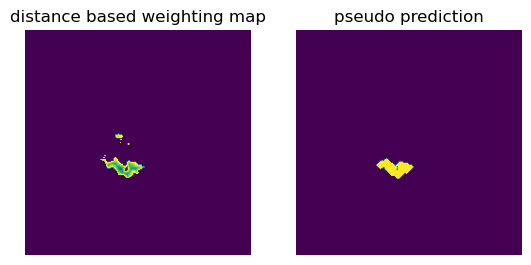

In [8]:
plt.subplot(121)
plt.imshow(gt[:,:,95])
plt.axis('off')
plt.title('distance based weighting map')
plt.subplot(122)
plt.title('pseudo prediction')
plt.axis('off')
plt.imshow(pred[:,:,95]>0)

In [9]:
smoothedDice(gt>1,pred)

0.8277974088175516

In [2]:
#expand batch dimension for both tensors
dm_tensor = tf.Variable(np.expand_dims(gt,0))
#set pseudo prediction to probabilities
pred_tensor = tf.Variable(np.expand_dims((pred*.9)+.0001,0))

In [11]:
spatial_regularization_loss(dm_tensor,pred_tensor)


Dice component:
tf.Tensor(0.741472, shape=(), dtype=float32)
Spatially Weighted CE Component:
tf.Tensor(0.0043353285, shape=(), dtype=float32)
Total Loss:


<tf.Tensor: shape=(), dtype=float32, numpy=0.25896153>

In [12]:
smoothedDice(tf.cast(dm_tensor>1,tf.float32),tf.cast(pred_tensor>.5,tf.float32))

0.8277974088175516